In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
from vqVAE import VQVAE

/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def reconstruct2(batch, model):
    z_e = model.encode(batch.float().to(device))[0]
    z_q, _ , _= model.vq_layer(z_e)
    img_hat = model.decode(z_q)
    return img_hat

def reconstruct(batch, model):
    output, _, _, _ = model(batch.float())
    return output

def save_model(model, epoch, ):
    checkpoint_path = os.path.join( os.getcwd() , model_name )
    torch.save({'epoch' : epoch,
                'model_state_dict': model.state_dict()}, checkpoint_path)

def visualize_batch(batch, title):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)

    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray')
        axes[i,1].imshow(img[1,:,:], cmap = 'gray')
        axes[i,2].imshow(img[2,:,:], cmap = 'gray')
        axes[i,3].imshow(img[3,:,:], cmap = 'gray')
        # axes[i].axis('off')

    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Preparing Dataset 

In [3]:
L = 128 # image size L=W
BATCH_SIZE = 16

In [4]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


In [5]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

NiftiImageIO (0x8c1aec0): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8c1aec0): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8d8de20): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame16_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8d8de20): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame16_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8adf6b0): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8adf6b0): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x8d70090): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame11_gt.nii.gz has unexpected scales in

## Prepairing the model

In [6]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 

In [7]:
ACDC_VQVAE = VQVAE(in_channels, D, K)

input = torch.rand(16, 4, 128, 128)

In [8]:
y = ACDC_VQVAE(input)
z_e = ACDC_VQVAE.encode(input)[0]
z_q, _ , _= ACDC_VQVAE.vq_layer(z_e)
codeBook = ACDC_VQVAE.vq_layer.embedding

## Training the Model

In [9]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [10]:
### Learning parameters

model = ACDC_VQVAE.to(device)

lr = 1e-3
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'saved_models/vqvae_106_bestmodel.pth'


In [11]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

In [12]:
###########################        Training ....      #################################
def dice_loss(preds, targets, smooth=1e-6):
    """
    Calculate Dice Loss across the 4 segmentation channels.
    :param preds: Predicted output tensor of shape [batch_size, 4, height, width]
    :param targets: Ground truth one-hot tensor of shape [batch_size, 4, height, width]
    :param smooth: A small value to avoid division by zero
    :return: Dice Loss (scalar)
    """
    # Ensure that the prediction is in probability space (use softmax if logits are provided)
    # Uncomment the following line if your model does not already output probabilities
    preds = F.softmax(preds, dim=1)  # Apply softmax over channel dimension (4 channels)

    # Flatten predictions and targets to calculate Dice coefficient for each channel
    preds_flat = preds.contiguous().view(preds.shape[0], preds.shape[1], -1)  # [batch_size, 4, height*width]
    targets_flat = targets.contiguous().view(targets.shape[0], targets.shape[1], -1)  # [batch_size, 4, height*width]

    intersection = (preds_flat * targets_flat).sum(dim=2)  # Summing over height and width dimensions
    union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)  # Sum of both sets

    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)  # Dice coefficient per channel
    dice_loss = 1 - dice_coeff.mean()  # Average over the batch and channels

    return dice_loss


def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch.float().to(device)
           
            outputs, _, _, _ = model(inputs)
            outputs_binary = F.softmax(outputs, dim=1)
            
            # Loss and backward
            loss = dice_loss(inputs, outputs)
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    return avg_val_loss


model.train()
train_loss_values = []
codebook_loss_values = []
commit_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0
    commit_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()
            commit_loss_epoch += commit_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)
    commit_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)
    commit_loss_values.append(commit_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model, epoch)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/119 [00:00<?, ?batch/s]

100%|██████████| 119/119 [00:08<00:00, 13.55batch/s, loss=0.894]


Epoch 0: Train Loss: 3.1852


100%|██████████| 119/119 [00:07<00:00, 14.98batch/s, loss=0.836]


Epoch 1: Train Loss: 0.8110


100%|██████████| 119/119 [00:07<00:00, 15.54batch/s, loss=0.743]


Epoch 2: Train Loss: 0.8109


100%|██████████| 119/119 [00:07<00:00, 15.12batch/s, loss=0.817]


Epoch 3: Train Loss: 0.8110


100%|██████████| 119/119 [00:08<00:00, 14.78batch/s, loss=0.881]


Epoch 4: Train Loss: 0.8110


100%|██████████| 119/119 [00:07<00:00, 16.00batch/s, loss=0.654]


Epoch 5: Train Loss: 0.8108


100%|██████████| 119/119 [00:07<00:00, 15.41batch/s, loss=0.82] 


Epoch 6: Train Loss: 0.8110


100%|██████████| 119/119 [00:07<00:00, 15.42batch/s, loss=0.9]  


Epoch 7: Train Loss: 0.8111


100%|██████████| 119/119 [00:07<00:00, 15.38batch/s, loss=0.736]


Epoch 8: Train Loss: 0.8109


100%|██████████| 119/119 [00:07<00:00, 15.39batch/s, loss=0.688]


Epoch 9: Train Loss: 0.8108


100%|██████████| 119/119 [00:07<00:00, 15.25batch/s, loss=0.816]


Epoch 10: Train Loss: 0.8110


100%|██████████| 119/119 [00:07<00:00, 15.59batch/s, loss=0.707]


Epoch 11: Train Loss: 0.8108


100%|██████████| 119/119 [00:07<00:00, 15.43batch/s, loss=0.78] 


Epoch 12: Train Loss: 0.8109


100%|██████████| 119/119 [00:07<00:00, 16.10batch/s, loss=0.891]


Epoch 13: Train Loss: 0.8110


100%|██████████| 119/119 [00:07<00:00, 15.66batch/s, loss=0.805]


Epoch 14: Train Loss: 0.8110


100%|██████████| 119/119 [00:07<00:00, 15.62batch/s, loss=0.921]


Epoch 15: Train Loss: 0.8111


100%|██████████| 119/119 [00:07<00:00, 15.64batch/s, loss=0.851]


Epoch 16: Train Loss: 0.8110


100%|██████████| 119/119 [00:07<00:00, 15.93batch/s, loss=0.758]


Epoch 17: Train Loss: 0.8109


100%|██████████| 119/119 [00:07<00:00, 15.81batch/s, loss=0.783]


Epoch 18: Train Loss: 0.8109


100%|██████████| 119/119 [00:07<00:00, 15.73batch/s, loss=0.77] 


Epoch 19: Train Loss: 0.8109


100%|██████████| 119/119 [00:07<00:00, 15.57batch/s, loss=0.783]


Epoch 20: Train Loss: 0.8109


100%|██████████| 119/119 [00:07<00:00, 15.67batch/s, loss=0.691]


Epoch 21: Train Loss: 0.8108


100%|██████████| 119/119 [00:07<00:00, 15.79batch/s, loss=0.793]


Epoch 22: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 18.12batch/s, loss=0.802]


Epoch 23: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.50batch/s, loss=0.821]


Epoch 24: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.16batch/s, loss=0.679]


Epoch 25: Train Loss: 0.8108


100%|██████████| 119/119 [00:05<00:00, 20.44batch/s, loss=0.912]


Epoch 26: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.58batch/s, loss=0.768]


Epoch 27: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.02batch/s, loss=0.818]


Epoch 28: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.51batch/s, loss=0.861]


Epoch 29: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.45batch/s, loss=0.854]


Epoch 30: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.49batch/s, loss=0.82] 


Epoch 31: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.29batch/s, loss=0.83] 


Epoch 32: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.01batch/s, loss=0.757]


Epoch 33: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.19batch/s, loss=0.924]


Epoch 34: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.48batch/s, loss=0.849]


Epoch 35: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.20batch/s, loss=0.851]


Epoch 36: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.20batch/s, loss=0.791]


Epoch 37: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.46batch/s, loss=0.824]


Epoch 38: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.45batch/s, loss=0.781]


Epoch 39: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 19.88batch/s, loss=0.665]


Epoch 40: Train Loss: 0.8108


100%|██████████| 119/119 [00:05<00:00, 20.43batch/s, loss=0.803]


Epoch 41: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.13batch/s, loss=0.812]


Epoch 42: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.85batch/s, loss=0.788]


Epoch 43: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.14batch/s, loss=0.844]


Epoch 44: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.19batch/s, loss=0.838]


Epoch 45: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.97batch/s, loss=0.813]


Epoch 46: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.04batch/s, loss=0.79] 


Epoch 47: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 19.99batch/s, loss=0.867]


Epoch 48: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.43batch/s, loss=0.859]


Epoch 49: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.40batch/s, loss=0.824]


Epoch 50: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.13batch/s, loss=0.707]


Epoch 51: Train Loss: 0.8108


100%|██████████| 119/119 [00:05<00:00, 20.47batch/s, loss=0.869]


Epoch 52: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.69batch/s, loss=0.796]


Epoch 53: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.40batch/s, loss=0.761]


Epoch 54: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.77batch/s, loss=0.832]


Epoch 55: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.32batch/s, loss=0.779]


Epoch 56: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.30batch/s, loss=0.799]


Epoch 57: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.35batch/s, loss=0.808]


Epoch 58: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.60batch/s, loss=0.704]


Epoch 59: Train Loss: 0.8108


100%|██████████| 119/119 [00:05<00:00, 20.54batch/s, loss=0.822]


Epoch 60: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.96batch/s, loss=0.704]


Epoch 61: Train Loss: 0.8108


100%|██████████| 119/119 [00:05<00:00, 20.41batch/s, loss=0.769]


Epoch 62: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.50batch/s, loss=0.917]


Epoch 63: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.59batch/s, loss=0.807]


Epoch 64: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.58batch/s, loss=0.792]


Epoch 65: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.67batch/s, loss=0.927]


Epoch 66: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.47batch/s, loss=0.854]


Epoch 67: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.94batch/s, loss=0.833]


Epoch 68: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.16batch/s, loss=0.814]


Epoch 69: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.21batch/s, loss=0.844]


Epoch 70: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.65batch/s, loss=0.815]


Epoch 71: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.74batch/s, loss=0.833]


Epoch 72: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.15batch/s, loss=0.821]


Epoch 73: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.66batch/s, loss=0.762]


Epoch 74: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.72batch/s, loss=0.833]


Epoch 75: Train Loss: 0.8123


100%|██████████| 119/119 [00:05<00:00, 20.17batch/s, loss=0.831]


Epoch 76: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.42batch/s, loss=0.913]


Epoch 77: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.47batch/s, loss=0.82] 


Epoch 78: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.46batch/s, loss=0.758]


Epoch 79: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.51batch/s, loss=0.82] 


Epoch 80: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.02batch/s, loss=0.807]


Epoch 81: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.64batch/s, loss=0.822]


Epoch 82: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.42batch/s, loss=0.773]


Epoch 83: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.34batch/s, loss=0.814]


Epoch 84: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.58batch/s, loss=0.806]


Epoch 85: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.27batch/s, loss=0.85] 


Epoch 86: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.43batch/s, loss=0.716]


Epoch 87: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 19.67batch/s, loss=0.873]


Epoch 88: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.07batch/s, loss=0.772]


Epoch 89: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.23batch/s, loss=0.741]


Epoch 90: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.31batch/s, loss=0.878]


Epoch 91: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.41batch/s, loss=0.861]


Epoch 92: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.02batch/s, loss=0.8]  


Epoch 93: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.65batch/s, loss=0.844]


Epoch 94: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.25batch/s, loss=0.836]


Epoch 95: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.15batch/s, loss=0.76] 


Epoch 96: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.03batch/s, loss=0.687]


Epoch 97: Train Loss: 0.8108


100%|██████████| 119/119 [00:05<00:00, 20.41batch/s, loss=0.782]


Epoch 98: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.27batch/s, loss=0.765]


Epoch 99: Train Loss: 0.8109
Training complete.


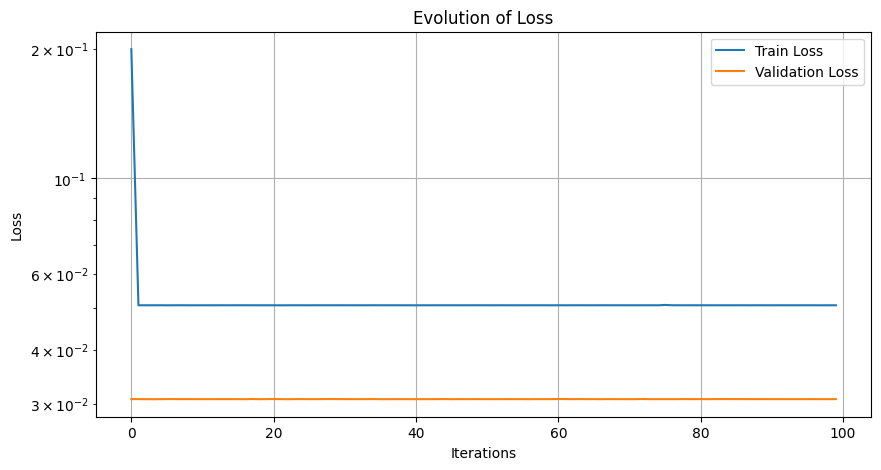

In [18]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of Loss')
plt.legend()
plt.grid()
plt.show()

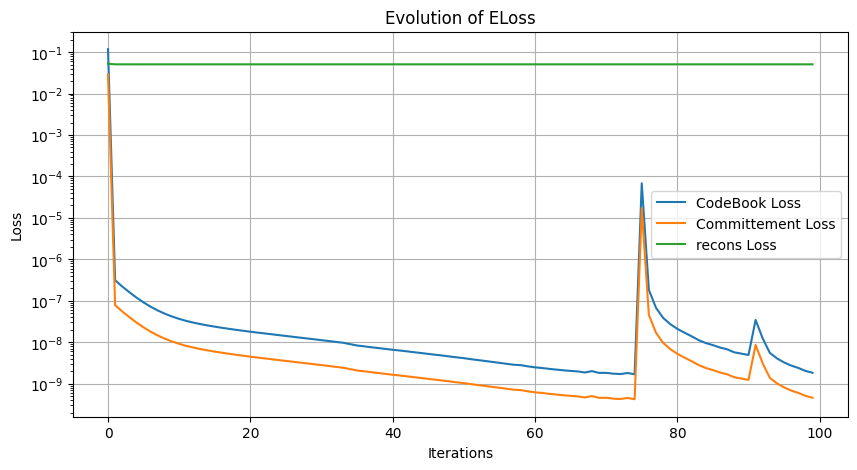

In [19]:
recons_loss_values = np.array(train_loss_values) - (np.array(commit_loss_values) + np.array(codebook_loss_values))
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
# plt.plot(train_loss_values, label='Train Loss')
# plt.plot(val_loss_values, label='Validation Loss')
plt.plot(codebook_loss_values, label = "CodeBook Loss")
plt.plot(commit_loss_values, label = "Committement Loss")
plt.plot(recons_loss_values, label = "recons Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of ELoss')
plt.legend()
plt.grid()
plt.show()

# Test ...

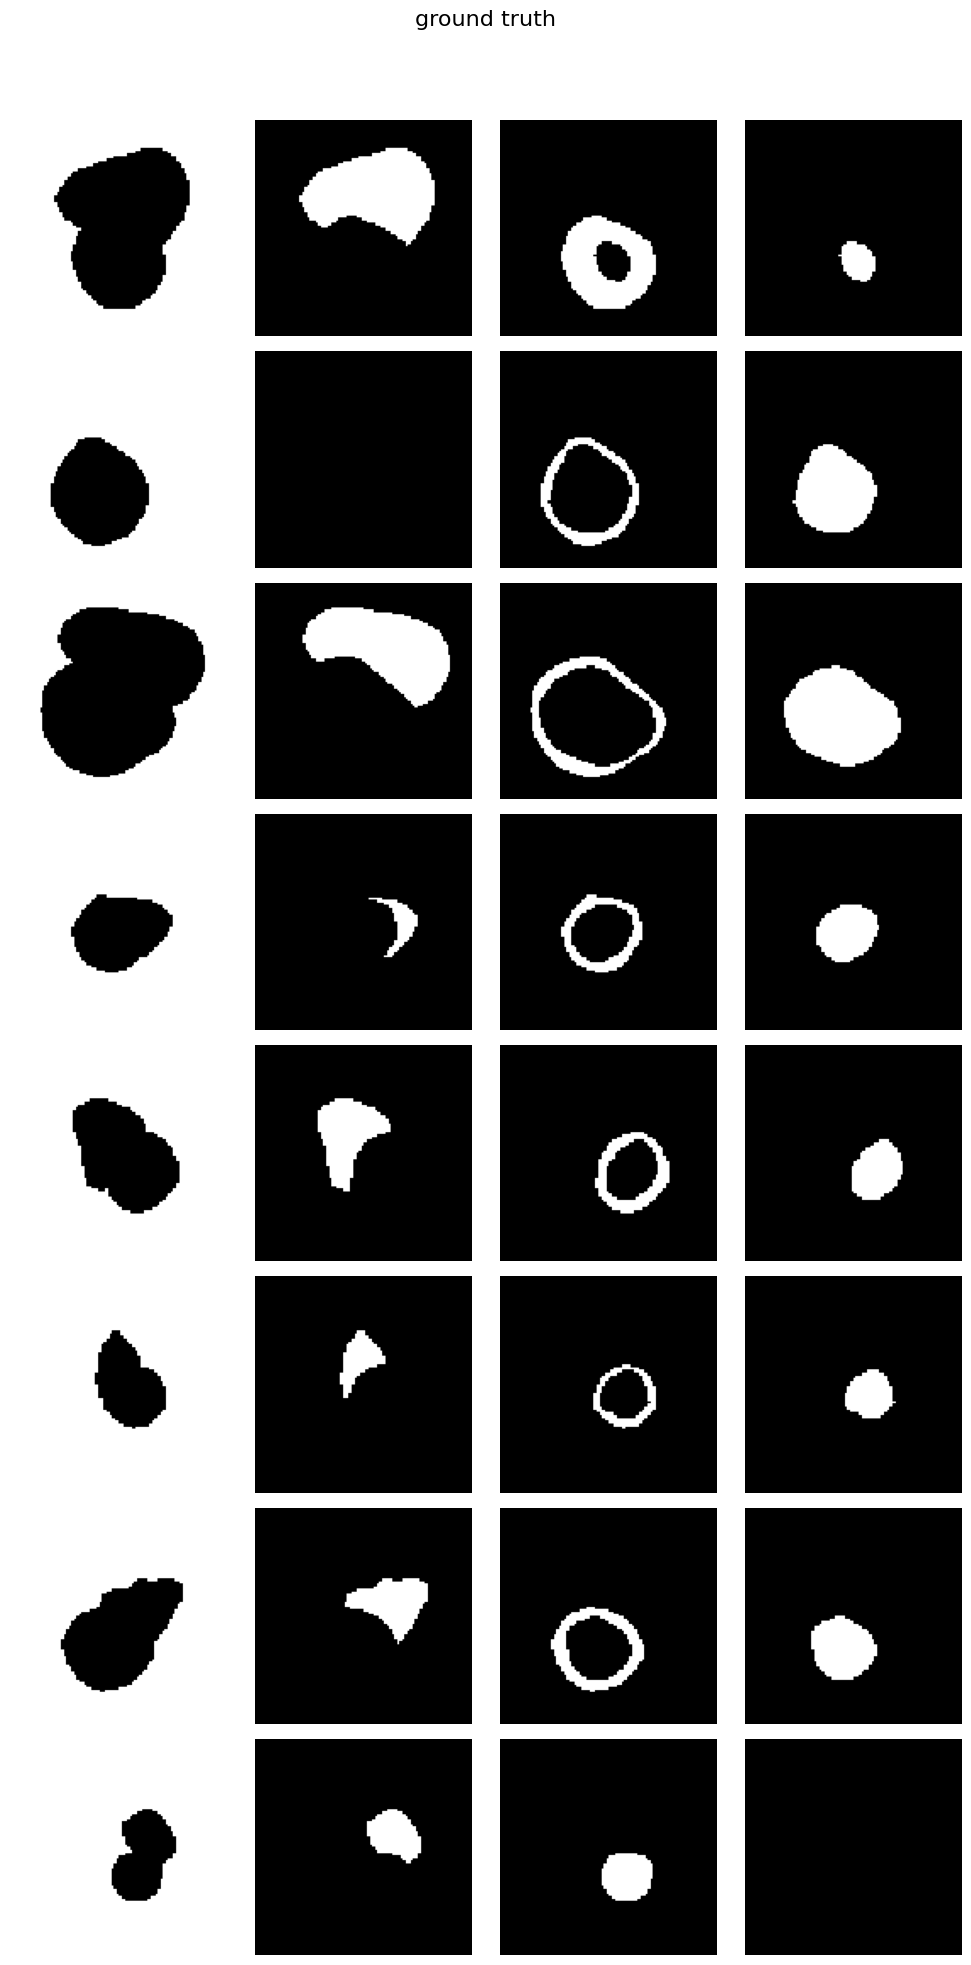

In [20]:
visualize_batch(vis_batch.detach().cpu(), title = "ground truth")

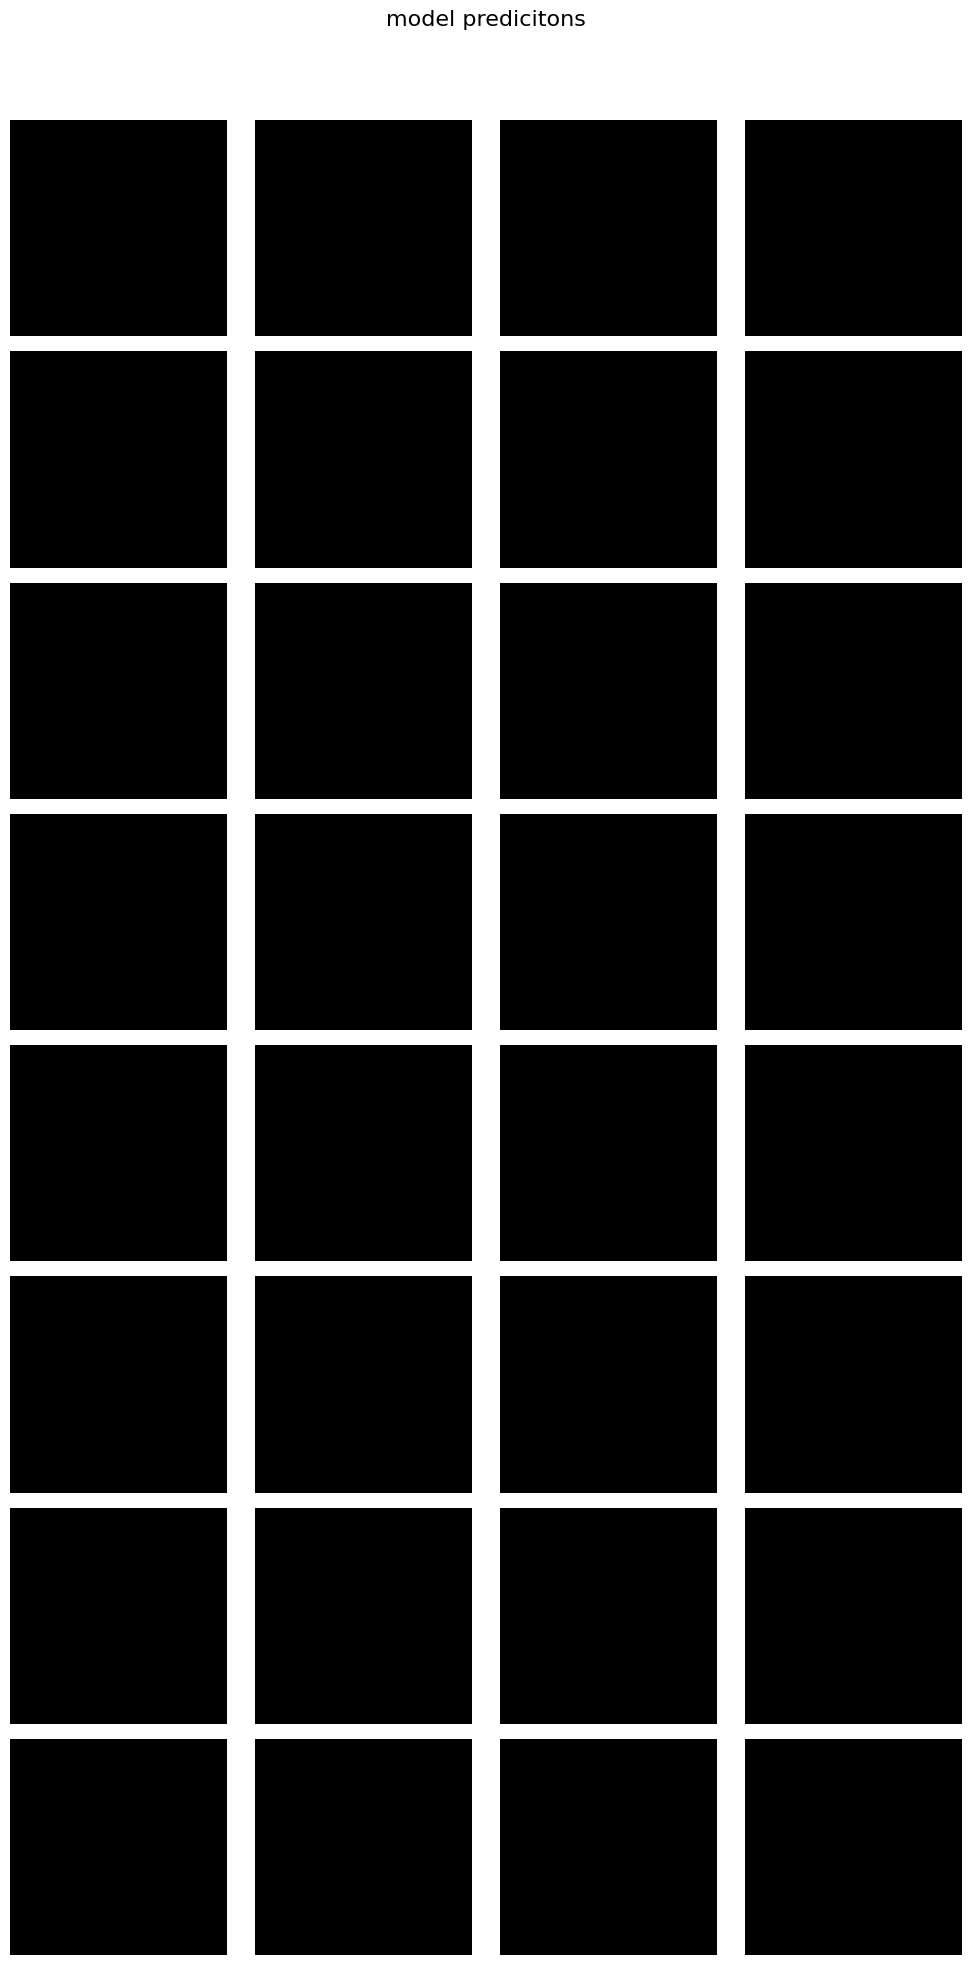

In [21]:
batch_hat = reconstruct(vis_batch, model)

visualize_batch( batch_hat.detach().cpu(), title = "model predicitons")

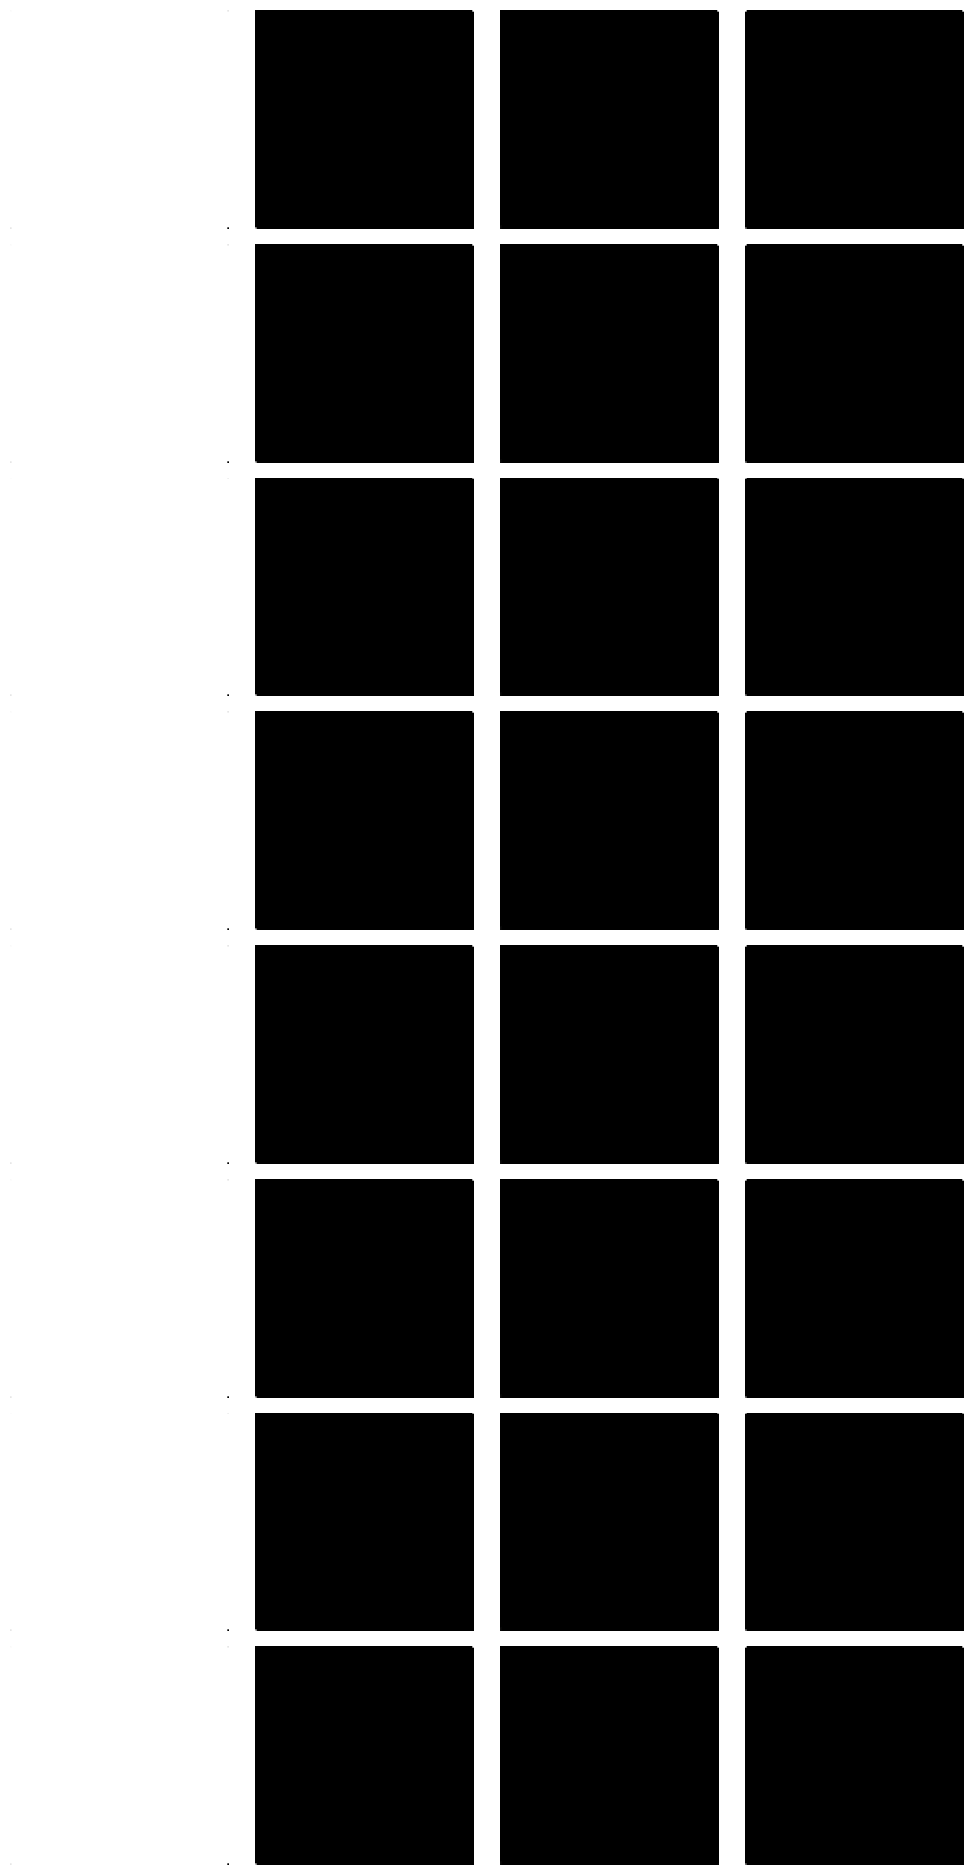

In [22]:
visualize_batch(recons_evolution[-1].detach().cpu(), title = "")